In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
import os 

In [4]:
covid_path=('Xray/Xray/covid/')
normal_path=('Xray/Xray/normal/')

In [5]:
train_path = 'Xray_new/Xray/train/'

In [6]:
test_path = 'Xray_new/Xray/test/'

In [7]:
val_path = 'Validation/Xray_val/'

In [8]:
# re-size all the images to a size VGG-16 expects.
IMAGE_SIZE = [224, 224]

# Set the batch size
BATCH_SIZE = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS = 5
LEARNING_RATE = 0.0001
NUM_CLASSES = 2 # We are aware of it.

In [9]:
import os
CLASSES = os.listdir(train_path)
NUM_CLASSES = len(CLASSES)

In [10]:
print("Class --> {} \n and the length is : {}".format(CLASSES, NUM_CLASSES))

Class --> ['covid', 'normal'] 
 and the length is : 2


In [11]:
# Image Data Augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [12]:
# Import the images from the train dataset.
# Make sure to provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 1941 images belonging to 2 classes.


# For Test Dataset

In [13]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
# Import the images from the test dataset.

test_set = test_datagen.flow_from_directory(
    directory = test_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 391 images belonging to 2 classes.


# Import the VGG-16 library / Create Base-Model

In [15]:
# Import the VGG 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 6s 0us/step


In [16]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = True

In [17]:
### Sample... for adding Pooling (optional)
# global_average_layer = GlobalAveragePooling2D()

# prediction = Dense(NUM_CLASSES,activation='softmax')

In [18]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(NUM_CLASSES, activation='softmax')(x)

In [19]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='Adam',
  metrics=['accuracy']
)

In [26]:
# fit the model

# history = model.fit_generator(
#   training_set,
#   validation_data=test_set,
#   epochs=5,
#   steps_per_epoch=len(training_set),
#   validation_steps=len(test_set)
# )

history = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=training_set.samples // 32,
  validation_steps=test_set.samples // 32,
    batch_size=100
)

Epoch 1/5
60/60 [==============================] - 144s 2s/step - loss: 0.1574 - accuracy: 0.9464 - val_loss: 0.1303 - val_accuracy: 0.9531
Epoch 2/5
60/60 [==============================] - 163s 3s/step - loss: 0.3192 - accuracy: 0.9136 - val_loss: 0.0639 - val_accuracy: 0.9818
Epoch 3/5
60/60 [==============================] - 173s 3s/step - loss: 0.0892 - accuracy: 0.9728 - val_loss: 0.0564 - val_accuracy: 0.9766
Epoch 4/5
60/60 [==============================] - 172s 3s/step - loss: 0.0696 - accuracy: 0.9770 - val_loss: 0.0593 - val_accuracy: 0.9792
Epoch 5/5
60/60 [==============================] - 172s 3s/step - loss: 0.0541 - accuracy: 0.9853 - val_loss: 0.0450 - val_accuracy: 0.9922


In [28]:
model.save('covid_VGG16.h5')

# Evaluate the Model

In [29]:
val_path = 'Xray_new/Xray/test/'

In [30]:
# Generate Validation set.
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory(
    directory = val_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 391 images belonging to 2 classes.


In [32]:
# Generate Validation set.
validation_set2 = validation_datagen.flow_from_directory(
    directory = val_path,
    target_size = (224, 224),
    batch_size = 1,
    shuffle=False, 
    seed=42, 
    class_mode="binary"
)

# validation_set2.reset()

Found 391 images belonging to 2 classes.


# Learning curves

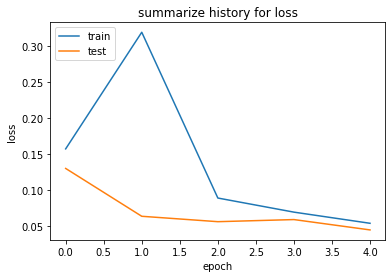

In [34]:
# summarize history for loss

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation (Test) loss')
plt.title('summarize history for loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

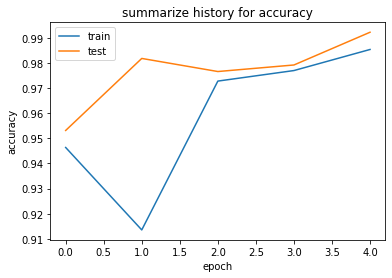

In [35]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('summarize history for accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predict

In [46]:
# get sample image to test.
img_normal = image.load_img('Xray_new/Xray/test/normal/NORMAL (100).png', target_size = (224, 224))
img_covid = image.load_img('Xray_new/Xray/test/covid/815.png', target_size = (224, 224))

In [47]:
def model_predict(img, actual):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x_processed = preprocess_input(x)
    result = model.predict(x_processed)
    if(result[0][0]<.50):
        result="normal"
    else:
        result="corona positive"
        
    plt.figure()
    plt.imshow(img)
    plt.title('Actual : {} --> Predicted  : {}'.format(actual, result))
    
#     return result

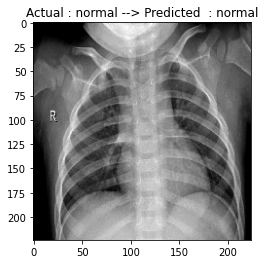

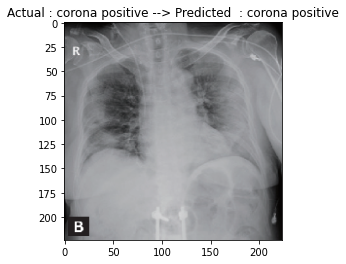

In [48]:
pred_normal = model_predict(img_normal, "normal")
pred_covid = model_predict(img_covid, "corona positive")